In [2]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

from torch.utils.tensorboard import SummaryWriter


In [3]:
#import dataset
df = pd.read_csv('dataset-ml-25m/dataset.csv')

### Data Prepocessing

In [4]:
#split data and labels 
X = df.drop(['rating'], axis=1)
y = df['rating']

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)
#count the numebr of x_train 
print("Number of train set: ", X_train.shape[0])
print("Number of validation set: ", X_val.shape[0])
print("Numebr of test set: ", X_test.shape[0])

Number of train set:  9946
Number of validation set:  1106
Numebr of test set:  2764


In [5]:
#PCA
pca = PCA(n_components=0.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [6]:
# T-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=500)
X_train_tsne = tsne.fit_transform(X_train)


/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


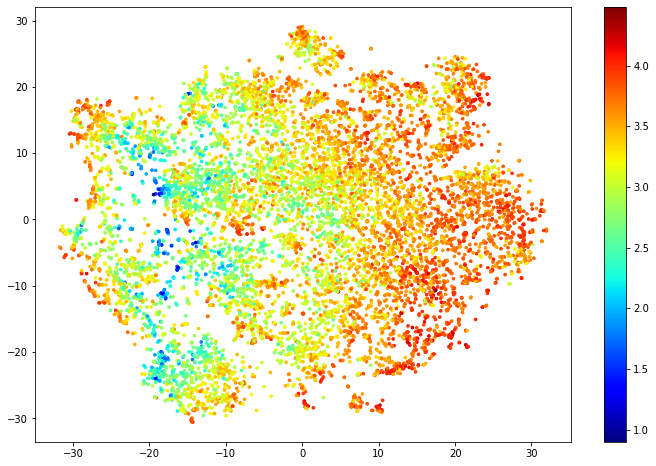

In [7]:
plt.figure(figsize=(12, 8))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap="jet", s=7)
plt.colorbar()

plt.show()

### Linear Regressor

In [8]:
log_name = f"linear_regression"
writer = SummaryWriter(f"results/tradML/pca/LinearRegression/{log_name}")

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)
y_pred = lin_regr.predict(X_test)

# Compute the RSS
mse = mean_squared_error(y_test, y_pred) 
print('Mean Square Error:', mse)
writer.add_scalar('Loss', mse)
writer.flush()

# Compute the R-square index
rsquare = r2_score(y_test, y_pred) 
print('R-square:', rsquare)


Mean Square Error: 0.006436841836992866
R-square: 0.9709615407207532


### Random Forest Regressor
TEST SET
Mean Squared Error:  0.03662117019915541

R2 Score:  0.8361367494911226

iper con pca = 30 e quared_error
91 min


In [9]:
param_grid = {
                "n_estimators": [10, 15, 20, 25, 30],
                "criterion": ["squared_error", "friedman_mse"]
              }
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)
best_no_leaves= grid_search.best_params_
print("Best number of leaves: ", best_no_leaves)


Best number of leaves:  {'criterion': 'squared_error', 'n_estimators': 30}


In [10]:
display(grid_search.cv_results_)
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/pca/RandomForestRegressor.csv")

{'mean_fit_time': array([ 33.81155257,  51.28429847,  71.89707155,  84.85322556,
        100.3173759 ,  36.21017027,  53.14016061,  69.59255157,
         86.44687095,  88.56684275]),
 'std_fit_time': array([ 0.75785321,  0.63531568,  0.76810023,  3.62503933,  2.19465786,
         1.8600989 ,  0.6091212 ,  1.38065343,  1.8892246 , 15.59613513]),
 'mean_score_time': array([0.02106318, 0.02095747, 0.13005872, 0.0417686 , 0.04618454,
        0.01871338, 0.01945105, 0.02256532, 0.03310008, 0.03415174]),
 'std_score_time': array([0.00824899, 0.00199705, 0.15180455, 0.01775577, 0.02538539,
        0.00439686, 0.00129339, 0.00149427, 0.0081795 , 0.01569375]),
 'param_criterion': masked_array(data=['squared_error', 'squared_error', 'squared_error',
                    'squared_error', 'squared_error', 'friedman_mse',
                    'friedman_mse', 'friedman_mse', 'friedman_mse',
                    'friedman_mse'],
              mask=[False, False, False, False, False, False, False, False,

In [11]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_n_estimators', 'param_criterion', 'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/pca/RandomForest/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    n_estimators = row['param_n_estimators']
    criterion = row['param_criterion']
    writer.add_hparams({"n_estimators": n_estimators, "criterion": criterion},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [12]:
rf = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
rf = rf.T
rf.to_csv('best_params/pca/random_forest.csv', index=False)

In [13]:
rf = RandomForestRegressor(n_estimators = 30, criterion = "squared_error")
rf= rf.fit(X_train,y_train)

y_pred= rf.predict(X_test)
print ("TEST SET")
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))


TEST SET
Mean Squared Error:  0.03768141853498311
R2 Score:  0.8300081988306942


### Ridge Regressor
Mean Squared Error:  0.006422342939029505

R2 Score:  0.9712629065606324

In [14]:
param_grid = {
                "alpha":[0.0001, 0.001, 0.1, 0.5, 1, 5, 10, 20]
              }
ridge = Ridge()
ridge.fit(X_train,y_train)
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper= grid_search.best_params_
print("Best number of leaves: ", best_hyper)


Best number of leaves:  {'alpha': 5}


In [15]:
display(grid_search.cv_results_)
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/pca/Ridge.csv")

{'mean_fit_time': array([0.08525944, 0.06620011, 0.06614084, 0.06562929, 0.06679301,
        0.06492925, 0.06441355, 0.06441641]),
 'std_fit_time': array([0.02451178, 0.00567546, 0.00156872, 0.00268047, 0.00092381,
        0.00265307, 0.00185051, 0.00237419]),
 'mean_score_time': array([0.00252156, 0.00196619, 0.00193434, 0.00154705, 0.00155663,
        0.00179839, 0.00149546, 0.0015296 ]),
 'std_score_time': array([7.85816922e-04, 5.28023004e-04, 5.78938604e-04, 5.47485894e-05,
        1.53003142e-04, 3.90151298e-04, 2.89293610e-05, 1.67010783e-04]),
 'param_alpha': masked_array(data=[0.0001, 0.001, 0.1, 0.5, 1, 5, 10, 20],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.0001},
  {'alpha': 0.001},
  {'alpha': 0.1},
  {'alpha': 0.5},
  {'alpha': 1},
  {'alpha': 5},
  {'alpha': 10},
  {'alpha': 20}],
 'split0_test_score': array([-0.0067141 , -0.00671408, -0.00671243, -0.00670631, -0.

In [16]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_alpha','mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/pca/Ridge")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    alpha = row['param_alpha']
    writer.add_hparams({"alpha": alpha},{"/hparam/mse": mse})
    writer.flush()
writer.close()

In [17]:
ridge = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
ridge = ridge.T
ridge.to_csv('best_params/pca/ridge.csv', index=False)

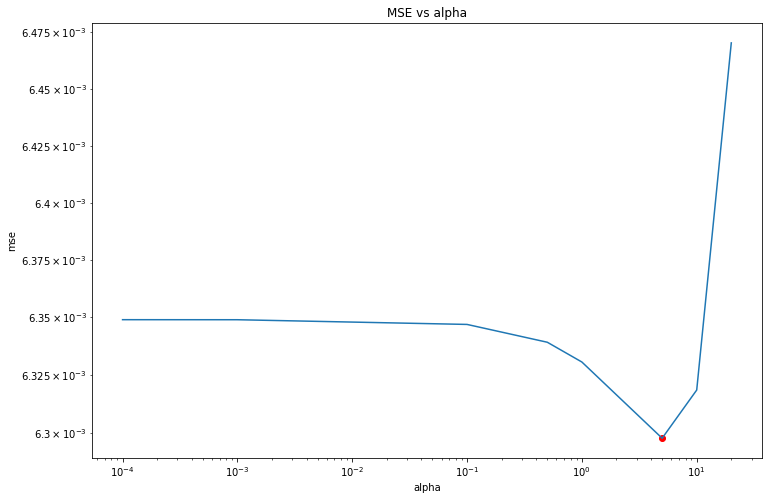

In [18]:
#plot mse vs alpha and put the red dot on the best alpha in base log scale and scale y in o.0001
plt.figure(figsize=(12, 8))
plt.plot(results['param_alpha'], results['mean_test_score'])
plt.scatter(best_hyper['alpha'], -1*grid_search.best_score_, c='r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('MSE vs alpha')
plt.show()

In [19]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

print("TEST SET")
y_pred= ridge.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))


TEST SET
Mean Squared Error:  0.006435515530873306
R2 Score:  0.9709675240720954


### KNN Regressor
Mean Squared Error:  0.04392172471123978

R2 Score:  0.8034700546159548

In [20]:
param_grid = {
                'n_neighbors': [3, 4, 5, 7, 8, 9, 10],
                'weights': ['uniform', 'distance']
              }
knn = KNeighborsRegressor()
knn.fit(X_train,y_train)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper= grid_search.best_params_
print("Best number of leaves: ", best_hyper)

Best number of leaves:  {'n_neighbors': 9, 'weights': 'distance'}


In [21]:
display(grid_search.cv_results_)
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/pca/KNN.csv")

{'mean_fit_time': array([0.01347151, 0.01281729, 0.01377192, 0.01326981, 0.01348701,
        0.01329408, 0.01370587, 0.01328297, 0.01360197, 0.01350932,
        0.01347947, 0.01356692, 0.01349239, 0.0135922 ]),
 'std_fit_time': array([0.00115775, 0.00089669, 0.00075122, 0.00035762, 0.00021803,
        0.00041557, 0.00059864, 0.00046474, 0.00082859, 0.00049591,
        0.00035891, 0.00031469, 0.00042995, 0.0003124 ]),
 'mean_score_time': array([0.42326093, 0.4015069 , 0.3847918 , 0.37051659, 0.39664187,
        0.40146613, 0.40241432, 0.4007452 , 0.39655261, 0.39835215,
        0.39830751, 0.3986105 , 0.39695644, 0.39952507]),
 'std_score_time': array([0.11326384, 0.02326907, 0.06292606, 0.02179458, 0.01722606,
        0.01860506, 0.0181987 , 0.0157984 , 0.02016708, 0.01661817,
        0.01962948, 0.01479552, 0.01638851, 0.01621091]),
 'param_n_neighbors': masked_array(data=[3, 3, 4, 4, 5, 5, 7, 7, 8, 8, 9, 9, 10, 10],
              mask=[False, False, False, False, False, False, False,

In [22]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_n_neighbors', 'param_weights', 'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/pca/KNN/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    n_neighbors = row['param_n_neighbors']
    weights = row['param_weights']
    writer.add_hparams({"n_neighbors": n_neighbors, "weights":weights},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [23]:
knn = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
knn = knn.T
knn.to_csv('best_params/pca/knn.csv', index=False)

In [24]:
knn = KNeighborsRegressor(n_neighbors= 10, weights= 'distance')
knn.fit(X_train, y_train)

print("TEST SET")
y_pred= knn.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

TEST SET
Mean Squared Error:  0.04020003586927806
R2 Score:  0.8186459860011652


### Lasso Regressor

Mean Squared Error:  0.006402684362671739

R2 Score:  0.971350869839928

In [25]:
param_grid = {
                'alpha':[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
              }
lasso = Lasso()
lasso.fit(X_train,y_train)
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper= grid_search.best_params_
print("Best values - Hyperparameters: ", best_hyper)

Best values - Hyperparameters:  {'alpha': 1e-05}


In [26]:
display(grid_search.cv_results_)
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/pca/Lasso.csv")

{'mean_fit_time': array([0.0681509 , 0.06868906, 0.06968608, 0.07311225, 0.08269343,
        0.08414497]),
 'std_fit_time': array([0.00162936, 0.00069891, 0.00115414, 0.00055271, 0.00220452,
        0.00119579]),
 'mean_score_time': array([0.00202198, 0.00156202, 0.00166507, 0.00196691, 0.00162182,
        0.00172067]),
 'std_score_time': array([5.67127621e-04, 1.10749328e-04, 9.58077755e-05, 6.99742135e-04,
        2.74268841e-05, 9.29510843e-05]),
 'param_alpha': masked_array(data=[0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.1},
  {'alpha': 0.01},
  {'alpha': 0.001},
  {'alpha': 0.0001},
  {'alpha': 1e-05},
  {'alpha': 1e-06}],
 'split0_test_score': array([-0.1131764 , -0.0423926 , -0.01226957, -0.00696979, -0.00667483,
        -0.00670902]),
 'split1_test_score': array([-0.1028737 , -0.03887757, -0.01152383, -0.00672968, -0.00635217,
        -0.0063

In [27]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_alpha','mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/pca/Lasso/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    alpha = row['param_alpha']
    writer.add_hparams({"alpha": alpha},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [28]:
lasso = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
lasso= lasso.T
lasso.to_csv('best_params/pca/lasso.csv', index=False)

In [29]:
lasso = Lasso(alpha = 1e-05)
lasso.fit(X_train, y_train)

print("TEST SET")
y_pred= lasso.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

TEST SET
Mean Squared Error:  0.006414757130601048
R2 Score:  0.9710611712326555


### SVR

Mean Squared Error:  0.0064680272514056085

R2 Score:  0.9710584898289305

51m

In [30]:
param_grid = {
                'kernel': ['linear', 'poly', 'rbf'],
                'epsilon': [0.001, 0.01, 0.1, 1]
              }
svr = SVR()
svr.fit(X_train,y_train)
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper = grid_search.best_params_
print("Best values - Hyperparameters: ", best_hyper)

Best values - Hyperparameters:  {'epsilon': 0.01, 'kernel': 'linear'}


In [31]:
display(grid_search.cv_results_)
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/pca/SVR.csv")

{'mean_fit_time': array([95.2244772 , 32.42477894, 37.32959871, 83.57090058, 19.95253434,
        24.76176085, 20.4101119 ,  9.45553899,  5.13805585,  0.09611611,
         0.19929194,  0.17561488]),
 'std_fit_time': array([1.54186406, 1.14358574, 0.51836457, 0.69130849, 0.90618208,
        0.49092027, 0.73369713, 0.05415712, 0.12988178, 0.00563121,
        0.00474232, 0.01941853]),
 'mean_score_time': array([4.22410841e+00, 4.27492204e+00, 6.75824075e+00, 3.81152129e+00,
        4.05105629e+00, 6.07923489e+00, 7.34484720e-01, 2.06080661e+00,
        1.58875899e+00, 6.72903061e-03, 1.81539536e-02, 3.09837818e-02]),
 'std_score_time': array([2.50811087e-02, 3.37823294e-02, 9.55563356e-01, 1.54158889e-02,
        2.06227307e-02, 7.90733301e-01, 1.53515586e-02, 1.35375483e-02,
        3.00465626e-02, 6.90242887e-04, 1.39617553e-03, 1.09587768e-03]),
 'param_epsilon': masked_array(data=[0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1,
                    1, 1, 1],
              mask=[F

In [32]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_kernel','param_epsilon' ,'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1


#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/pca/SVR/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    kernel = row['param_kernel']
    epsilon = row['param_epsilon']
    writer.add_hparams({"kernel": kernel, "epsilon":epsilon},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [33]:
svr = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
svr = svr.T
svr.to_csv('best_params/pca/svr.csv', index=False)

In [34]:
svr = SVR(kernel ='linear', epsilon = 0.01)
svr.fit(X_train, y_train)

print("TEST SET")
y_pred= svr.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

TEST SET
Mean Squared Error:  0.006458288950663027
R2 Score:  0.9708647865744281
